# MED 7 Machine leaning mini project
*Sebastian Whitehead 20204568*
*MED 7 2023*


The following code downloads a fresh copy of the data from the provided URL and extracts this data to a sub directory of the project folder.

In [7]:
import os
import urllib.request
import zipfile
import shutil

url = "https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip"
folder = "data"

#If folder already exists remove
if os.path.exists(folder):
    shutil.rmtree(folder)
    
os.makedirs(folder) # create data directory

compressedFile, _ = urllib.request.urlretrieve(url) # Get the zip file from the data url

with zipfile.ZipFile(compressedFile, 'r') as zip: # Extract the zipfile to the data folder
    zip.extractall(folder)
    
 # Delete the zipfile that was downloaded
os.remove(compressedFile)

Read the now dowloaded CSV file with the padas package and describe the data using the same package

In [12]:
import pandas as pd
from pathlib import Path

# Import the CSV file
csv_file = Path("data/Occupancy_Estimation.csv")
df = pd.read_csv(csv_file)

# Print the DataFrame

#df.head()
#print(df.info())
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


## Preliminary plotting of data
The following code uses matplotlib to plot the data in histogram format. This is done as a means to create a better understanding of the datas distrobution and scale, and will be used for considerations into what sort of transformations that will likly have to to the different sensor values.

<function matplotlib.pyplot.show(close=None, block=None)>

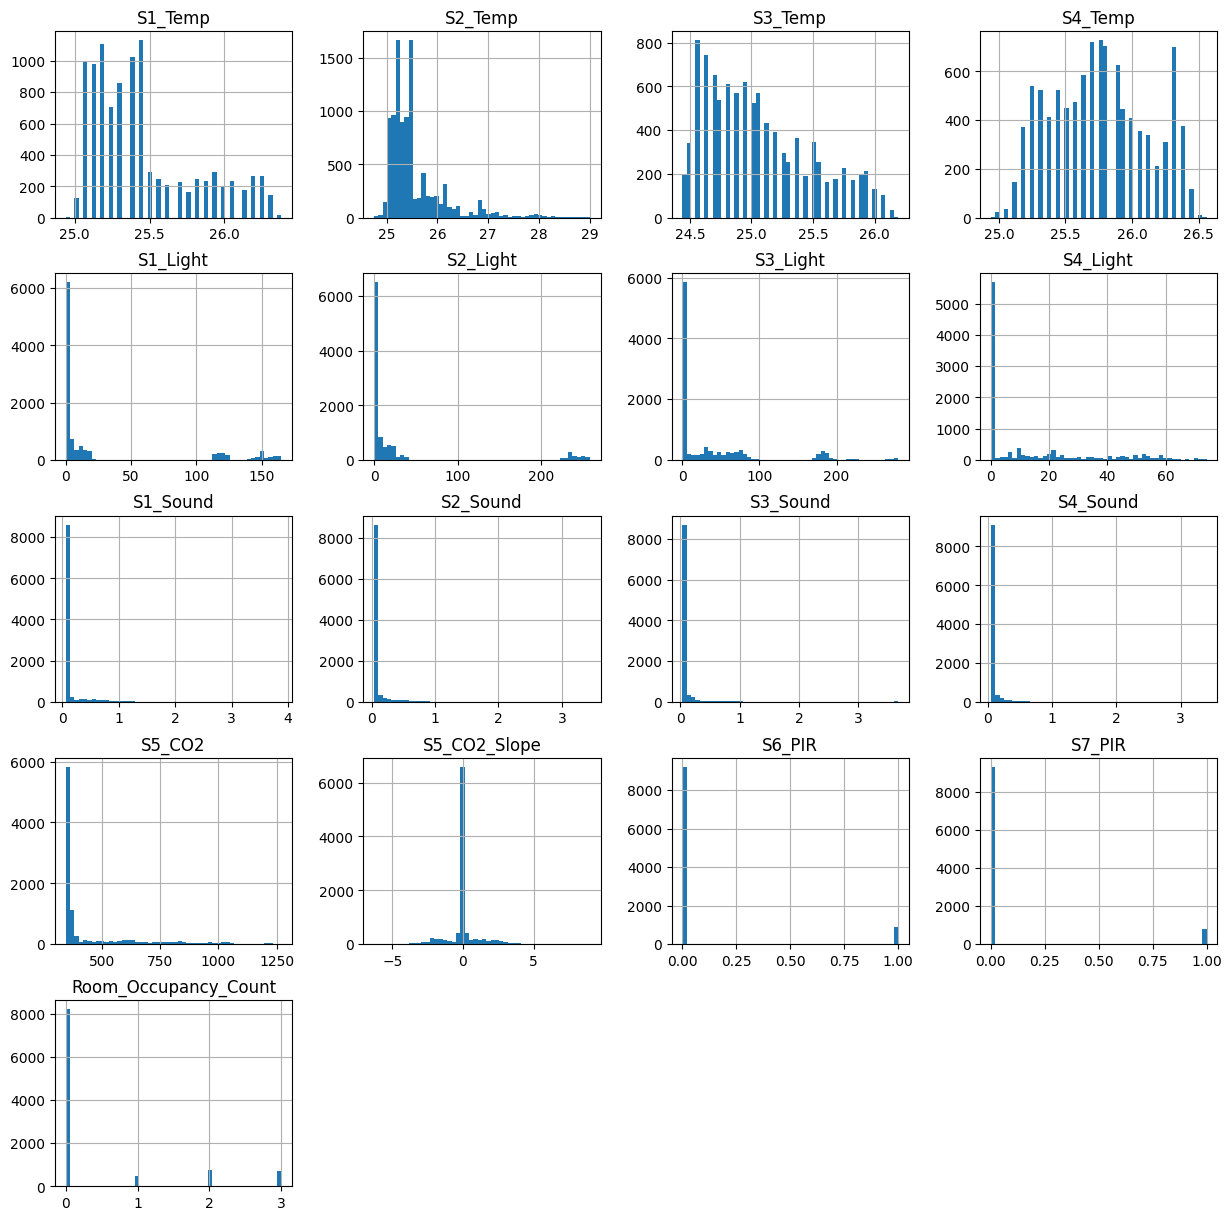

In [21]:
import matplotlib.pyplot as plt

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=7)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15, 15))
plt.show
